# Mooring analysis
This notebook is provided as part of the report about mooring timeseries collected in St.Jhonsfjorden in 2024 with the AGF211 course. The notebook is divided into several parts: 
1. Loading packages, setting parameters and loading the data (parts of this section be skipped when importing the data directly from the acompanying netCDF file)
2. Investigating the data and plotting contour plots and current direction plots
3. Tidal analysis on the SeaGuard RCMs
4. ADCP processing and analysis 

In [2]:
# IMPORTING MODULES

import xarray as xr
import pandas as pd
from datetime import datetime as dt 
import numpy as np
import gsw
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cmocean.cm as cmo

# CHANGE DATA DIRECTORY 
data_dir = '/Users/jorgemoran/Desktop/AGF211/DATA/AGF_211_2024/'

# Used in gsw SP_from_SA function
latitude = 78.5 
longitude = 12.56

# MICRO_CAT START TIME (weirdly, this is nowhere in the cnv file to retrieve it automatically)
MicroCat_StartTime = '04-04-2024 12:00:00'


# ROUGH TIMES, THE TIME IS SLICED AND SPECIFIED LATER 
# MOORING SUBMERSION TIME (+ 30min for the instruments to equalise)
MooringDown = '04-04-2024 14:00:00'

# MOORING RISE TIME 
MooringUp = '07-04-2024 10:00:00'


#converts string to datetime object
DateInit = dt.strptime(MicroCat_StartTime, '%d-%m-%Y %H:%M:%S')
MooringDown = dt.strptime(MooringDown, '%d-%m-%Y %H:%M:%S')
MooringUp = dt.strptime(MooringUp, '%d-%m-%Y %H:%M:%S')


In [3]:
def read_minilog(file, path = data_dir, mdown = MooringDown, mup = MooringUp):
    #read csv
    df = pd.read_csv(path + file, header = 7, delimiter = ",")

    #convert to datetime, set datetime as index, filter the dataset to the correct dates when the mooring was in the water. 
    df['Datetime'] = pd.to_datetime(df['Date(yyyy-mm-dd)'] + df['Time(hh:mm:ss)'], format='%Y-%m-%d%H:%M:%S')   
    df = df.set_index('Datetime')
    df = df.loc[mdown : mup]

    #drop redundant columns and rename
    df = df.drop(['Date(yyyy-mm-dd)', 'Time(hh:mm:ss)'], axis=1)
    df = df.rename(columns={'Temperature (C)' : 'T'})

    return df

def read_microCAT(file, DateInit = DateInit, path = data_dir, mdown = MooringDown, mup = MooringUp, P = None, lat = latitude, lon = longitude):
    # read csv
    df = pd.read_csv(data_dir + file, delimiter = ",")

    #convert to datetime, set datetime as index, filter the dataset to the correct dates when the mooring was in the water. 
    df['Datetime'] = DateInit + pd.to_timedelta(df['timeM'], 'm')
    df = df.set_index('Datetime')
    df = df.loc[mdown : mup]

    #drop redundant columns, rename variables, convert units
    df = df.drop(['timeM', 'flag'], axis=1)
    df = df.rename(columns={'t090C' : 'T', 'c0S/m' : 'C', 'prdM': 'P'})   
    df['C'] = df['C']*10     # convert S/m to mS/cm

    # some seabirds don't have a pressure sensor. In this case you can pass an optional paramenter P for the pressure (in dbar), roughly the same as depth
    if P != None:     #if P is a number, fill the pressure column with P. 
        df['P'] = P

    #convert C, T and P into practical salinity 
    df['Sp'] = gsw.conversions.SP_from_C(df['C'], df['T'], df['P'])
    df['Sa'] = gsw.conversions.SA_from_SP(df['Sp'], df['P'], lon, lat)


    return df

def read_seaGuard(file, path = data_dir, mdown = MooringDown, mup = MooringUp, P = None, lat = latitude, lon = longitude):
    # read txt file
    df = pd.read_csv(path + file, header = 4, delimiter = "\t")

    #convert to datetime, set datetime as index, filter the dataset to the correct dates when the mooring was in the water. 
    df['Datetime'] = pd.to_datetime(df['Time tag (Gmt)'], format = '%d.%m.%y %H:%M:%S')
    df = df.set_index('Datetime')
    df = df.loc[mdown : mup]

    #drop redundant columns and rename columns
    df = df.drop(['Record', 'Time tag (Gmt)', 'Battery Voltage(V)', 'Memory Used(Bytes)', 'Last Interval(ms)', 'Time Correction(ms)', 'Strength(dB)', 'SP Std(cm/s)', 'Ping Count', 'Std Tilt(Deg)', 'Strength X(dB)', 'Strength Y(dB)', 'Heading(Deg.M)'], axis=1)
    df = df.rename(columns={'Conductivity(mS/cm)' : 'C', 'East(cm/s)': 'U', 'North(cm/s)' : 'V', 'Abs Speed(cm/s)' : 'Abs_Speed', 'Direction(Deg.M)' : 'Dir'}) 

    # Seaguards have different column names & sensors. The readlines() function will store all lines which can then be read (serial number in position 2) to see which seaguard you have
    text = open(path + file, 'r') 
    lines = text.readlines()   

    # depending on which serial number it has, average the temperatures into one column and maybe rename some columns.  
    if lines[2] == 'Serial number:	1705\n':
        df['T'] = np.mean([df['Temperature(Deg.C)'], df['Temperature(Deg.C).1'], df['Temperature(Deg.C).2']], axis = 0) 
        df = df.drop(['Temperature(Deg.C)', 'Temperature(Deg.C).1', 'Temperature(Deg.C).2'], axis=1)

    elif lines[2] == 'Serial number:	1711\n':
        df['T'] = np.mean([df['Temperature(Deg.C)'], df['Temperature(Deg.C).1'], df['Temperature(DegC)']], axis = 0)
        df['P'] = df['Pressure(kPa)']/10     # Convert to dbar
        df = df.drop(['Temperature(Deg.C)', 'Temperature(Deg.C).1', 'Temperature(DegC)', 'Pressure(kPa)', 'Rawdata Temperature'], axis=1)

    if P != None:
        df['P'] = P

    df['Sp'] =  gsw.conversions.SP_from_C(df['C'], df['T'], df['P'])
    df['Sa'] = gsw.conversions.SA_from_SP(df['Sp'], df['P'], lon, lat)

    return df

def read_ADCP(file):
    df = pd.read_csv(data_dir + "ADCP_TXT.txt",  header = 10, delimiter = "\t")



def dict_to_xarray(mooring_dict, xr_vars = ['T', 'Sp', 'Sa', 'U', 'V', 'Abs_Speed', 'Dir', 'C', 'P']):
    '''
    Function which converts a mooring dictionary into an xarray dataset.
    
    Parameters: mooring_dict, a dictionary with keys as the depths and a dataframes as item. 
                The dataframe is from the read_Instrument functions, and corresponds to the instrument at that depth 

                xr_vars, the variables which will be retrieved from the instruments and placed in the xarray dataset
    
    The first part creates dataframes for each individual variable with depth columns and time rows. 

    The second part creates xr arrays from these new dataframes, and then     
    '''

    list_da = []                                     # Empty list which will be filled with depth-time data arrays for each of those variables
    for vari in xr_vars:                             # iterates over xr_vars
        list_df = []
        for d, df_instr in mooring.items():          # iterate over the mooring dictionary, with d as depth (key) and df_instr as the dataframe (item)
            if vari in list(df_instr.keys()):        # if the variable is present as a column in the instrument dataframe 
                var = df_instr[vari].rename(d)       # create a new dataframe with only the relevant variable, which is renamed according to it's depth 
                list_df.append(var)                  # add that dataframe to a list 
        df_var = pd.concat(list_df, axis=1)          # create a new dataframe concatenating the dataframes in the list. This dataframe is for each variable (eg, temp) with the depths as columns
    
        list_da.append(xr.DataArray(data=df_var, dims=["time", "depth"], coords={"depth": np.array(list(df_var.columns), dtype=float), "time": df_var.index.values}, name=vari))
    
    ds = xr.merge(list_da) #merges the dataarrays, such that you have all variables within a single dataarray     

    return ds

In [4]:
# CALLING THE READ FUNCTIONS TO EXTRACT ALL THE DATA

MicroCAT1 = read_microCAT('37-SM_03720169_2024_04_07_1.csv')
Minilog2 = read_minilog('Minilog-II-T_355582_20240407_1_2.csv')
Minilog3 = read_minilog('Minilog-II-T_355584_20240407_1_3.csv')
SeaGuard4 = read_seaGuard('Seaguard_4.txt', P = 26)
Minilog5 = read_minilog('Minilog-II-T_355581_20240407_1_5.csv')
Minilog6 = read_minilog('Minilog-II-T_358952_20240407_1_6.csv')
Minilog7 = read_minilog('Minilog-II-T_355575_20240407_1_7.csv')
Minilog8 = read_minilog('Minilog-II-T_355572_20240407_1_8.csv')
MicroCAT9 = read_microCAT('37-SM_03721530_2024_04_07_9.csv')
Minilog10 = read_minilog('Minilog-II-T_355570_20240407_1_10.csv')
Minilog11 = read_minilog('Minilog-II-T_355573_20240407_1_11.csv')
Minilog12 = read_minilog('Minilog-II-T_355579_20240407_1_12.csv')
Minilog13 = read_minilog('Minilog-II-T_355583_20240407_1_13.csv')
MicroCAT14 = read_microCAT('37-SM_03710967_2024_04_07_14.csv', P = 93)
Minilog15 = read_minilog('Minilog-II-T_358951_20240407_1_15.csv')
Minilog16 = read_minilog('Minilog-II-T_358947_20240407_1_16.csv')
SeaGuard17 = read_seaGuard('Seaguard_17.txt')
Minilog18 = read_minilog('Minilog-II-T_355571_20240407_1_18.csv')

# CONSTRUCTING THE MOORING (KEYS ARE INSTRUMENT DEPTHS) 
mooring = {
    1: MicroCAT1,
    10: Minilog2, 
    20: Minilog3,
    26: SeaGuard4,
    42: Minilog5, 
    52: Minilog6,
    62: Minilog7,
    68: Minilog8, 
    73: MicroCAT9,
    77: Minilog10,
    81: Minilog11,
    85: Minilog12,
    89: Minilog13,
    93: MicroCAT14,
    103: Minilog15,
    113: Minilog16,
    137: SeaGuard17,
    141: Minilog18
}

xr_mooring_raw = dict_to_xarray(mooring) # creates xarray from mooring dict


# reselecting time window
xr_mooring_slice = xr_mooring_raw.sel(time=slice('2024-04-04T18:45:00','2024-04-07T09:55:00'))

# dropping conductivity, practical and absolute salinity from the first sensor (faulty microCAT)
xr_mooring_slice['C'] = xr_mooring_slice.C.drop_sel(depth = 1)
xr_mooring_slice['Sp'] = xr_mooring_slice.Sp.drop_sel(depth = 1)
xr_mooring_slice['Sa'] = xr_mooring_slice.Sa.drop_sel(depth = 1)


xr_mooring_interp = xr_mooring_slice.interpolate_na(dim = "depth", method = 'linear')




In [5]:
xr_mooring_raw

<xarray.Dataset> Size: 1MB
Dimensions:    (depth: 18, time: 817)
Coordinates:
  * depth      (depth) float64 144B 1.0 10.0 20.0 26.0 ... 113.0 137.0 141.0
  * time       (time) datetime64[ns] 7kB 2024-04-04T14:00:00 ... 2024-04-07T1...
Data variables:
    T          (time, depth) float64 118kB -4.355 -4.29 -3.29 ... -1.228 -1.19
    Sp         (time, depth) float64 118kB 0.0002392 nan nan ... nan 34.64 nan
    Sa         (time, depth) float64 118kB 0.0002403 nan nan ... nan 34.8 nan
    U          (time, depth) float64 118kB nan nan nan 0.0 ... nan nan 2.734 nan
    V          (time, depth) float64 118kB nan nan nan 0.0 ... nan nan 3.535 nan
    Abs_Speed  (time, depth) float64 118kB nan nan nan 0.0 ... nan nan 4.47 nan
    Dir        (time, depth) float64 118kB nan nan nan 0.0 ... nan nan 37.72 nan
    C          (time, depth) float64 118kB 0.0009957 nan nan ... nan 27.76 nan
    P          (time, depth) float64 118kB -0.1093 nan nan ... nan 88.03 nan

# Data investigation and plotting basic timeseries, contourplots, etc

In [6]:
# verifying instrument depths for the instruments which log it 
print('Microcat1 Pmean:', np.mean(MicroCAT1['P']), '     Microcat9 Pmean:', np.mean(MicroCAT9['P']), '     Seaguard17 Pmean:', np.mean(SeaGuard17['P']))

Microcat1 Pmean: 1.2003516404263868      Microcat9 Pmean: 72.5904053936062      Seaguard17 Pmean: 136.05078824969402


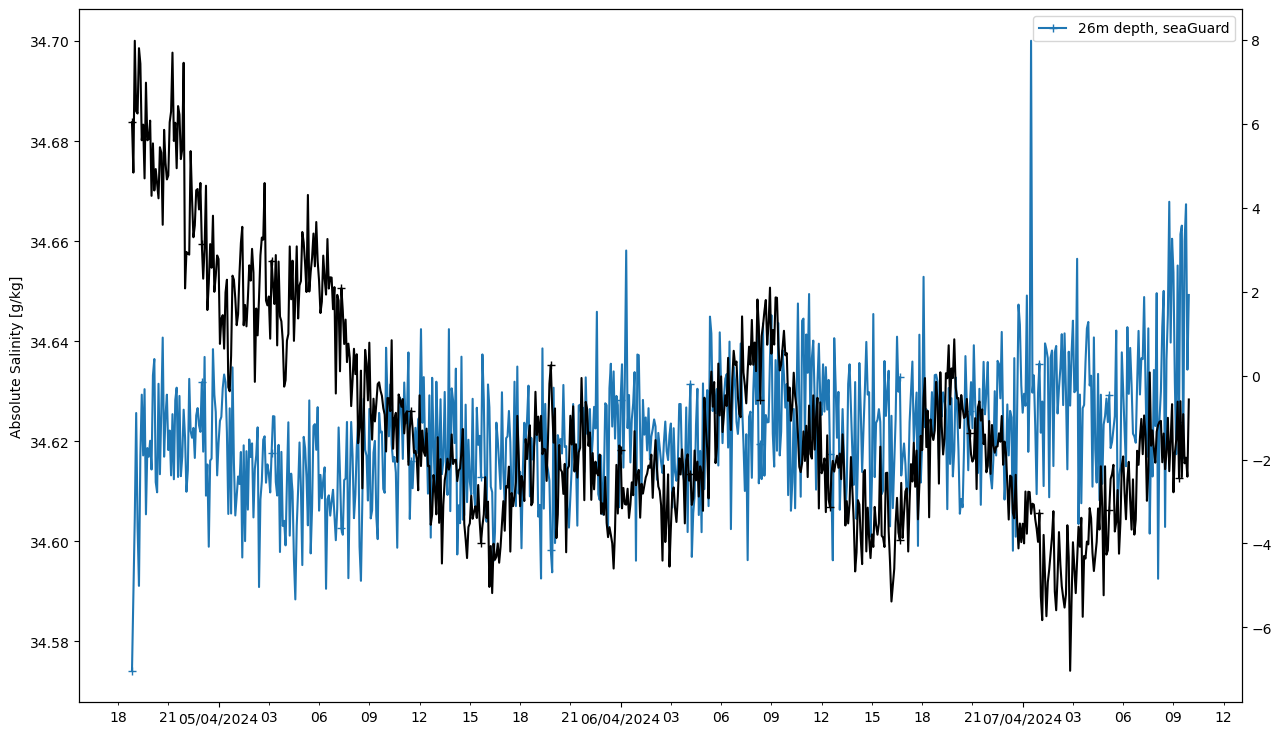

In [7]:
xr_mooring_plt = xr_mooring_raw.sel(time=slice('2024-04-04T18:50:00','2024-04-07T9:55:00'))


fig, axs = plt.subplots(figsize = (15,9), sharex = True)

#axs.plot(xr_mooring_plt.time, xr_mooring_plt.T.sel(depth = 1), label = '1m depth, microCAT', marker = 'o',markevery=50)

axs.plot(xr_mooring_plt.time, xr_mooring_plt.Sp.sel(depth = 26), label = '26m depth, seaGuard', marker = '+',markevery=50)

ax2 = axs.twinx()

ax2.plot(xr_mooring_plt.time, xr_mooring_plt.U.sel(depth = 26), label = '26m depth, seaGuard U', marker = '+',markevery=50, color = 'k')


#axs.plot(xr_mooring_plt.time, xr_mooring_plt.Sp.sel(depth = 73), label = '73m depth, microCAT', marker = 'v',markevery=50)

#axs.plot(xr_mooring_plt.time, xr_mooring_plt.Sp.sel(depth = 93), label = '93m depth, microCAT', marker = 'x',markevery=50)

#axs.plot(xr_mooring_plt.time, xr_mooring_plt.Sp.sel(depth = 137), label = '135m depth, seaGuard', marker = '^',markevery=50)


axs.legend()

axs.set_ylabel('Absolute Salinity [g/kg]')


locator_day = mdates.DayLocator()  # Tick on the start day with dd/mm/yyyy
formatter_day = mdates.DateFormatter('%d/%m/%Y')  # Format for displaying date

locator_hr = mdates.HourLocator(byhour = [0, 3, 6, 9, 12, 15, 18, 21])  # Tick every 6 hours
formatter_hr = mdates.DateFormatter('%H')  # Format for displaying hour


axs.xaxis.set_major_locator(locator_day)
axs.xaxis.set_major_formatter(formatter_day) 
axs.xaxis.set_minor_locator(locator_hr)
axs.xaxis.set_minor_formatter(formatter_hr)

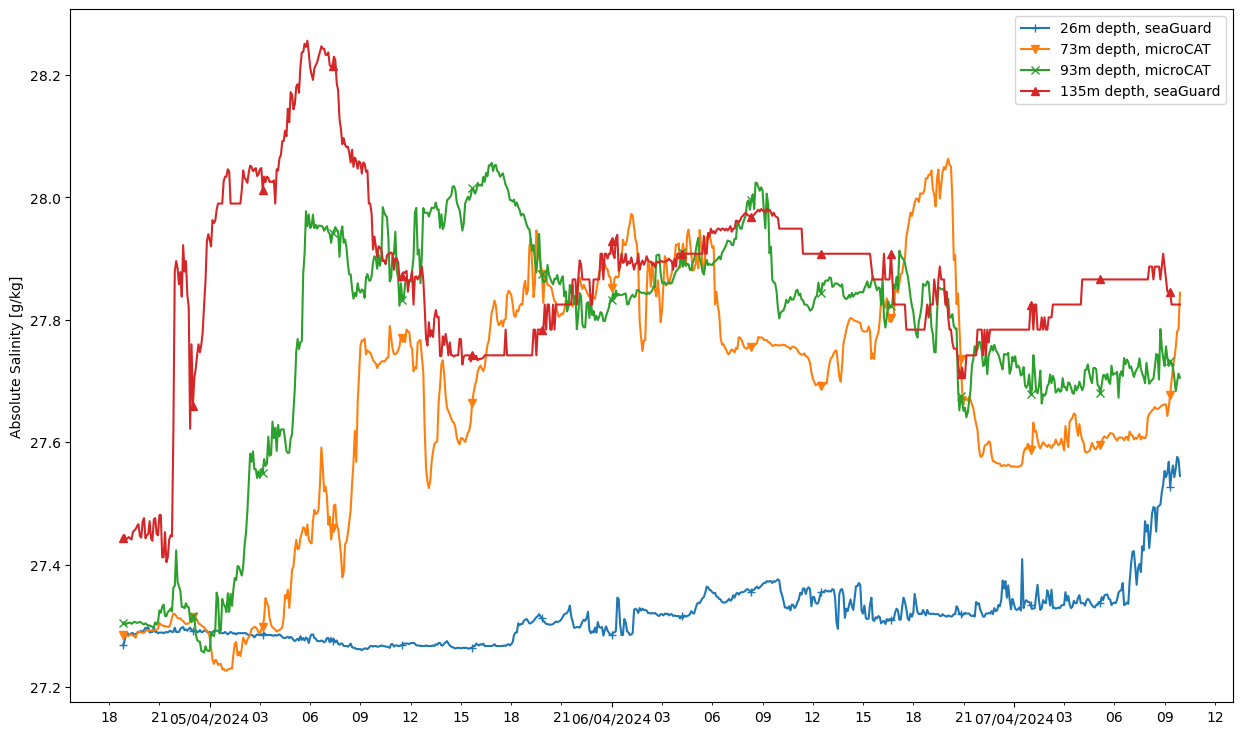

In [8]:
xr_mooring_plt = xr_mooring_raw.sel(time=slice('2024-04-04T18:50:00','2024-04-07T9:55:00'))


fig, axs = plt.subplots(figsize = (15,9), sharex = True)

#axs.plot(xr_mooring_plt.time, xr_mooring_plt.T.sel(depth = 1), label = '1m depth, microCAT', marker = 'o',markevery=50)

axs.plot(xr_mooring_plt.time, xr_mooring_plt.C.sel(depth = 26), label = '26m depth, seaGuard', marker = '+',markevery=50)

axs.plot(xr_mooring_plt.time, xr_mooring_plt.C.sel(depth = 73), label = '73m depth, microCAT', marker = 'v',markevery=50)

axs.plot(xr_mooring_plt.time, xr_mooring_plt.C.sel(depth = 93), label = '93m depth, microCAT', marker = 'x',markevery=50)

axs.plot(xr_mooring_plt.time, xr_mooring_plt.C.sel(depth = 137), label = '135m depth, seaGuard', marker = '^',markevery=50)


axs.legend()

axs.set_ylabel('Absolute Salinity [g/kg]')


locator_day = mdates.DayLocator()  # Tick on the start day with dd/mm/yyyy
formatter_day = mdates.DateFormatter('%d/%m/%Y')  # Format for displaying date

locator_hr = mdates.HourLocator(byhour = [0, 3, 6, 9, 12, 15, 18, 21])  # Tick every 6 hours
formatter_hr = mdates.DateFormatter('%H')  # Format for displaying hour


axs.xaxis.set_major_locator(locator_day)
axs.xaxis.set_major_formatter(formatter_day) 
axs.xaxis.set_minor_locator(locator_hr)
axs.xaxis.set_minor_formatter(formatter_hr)

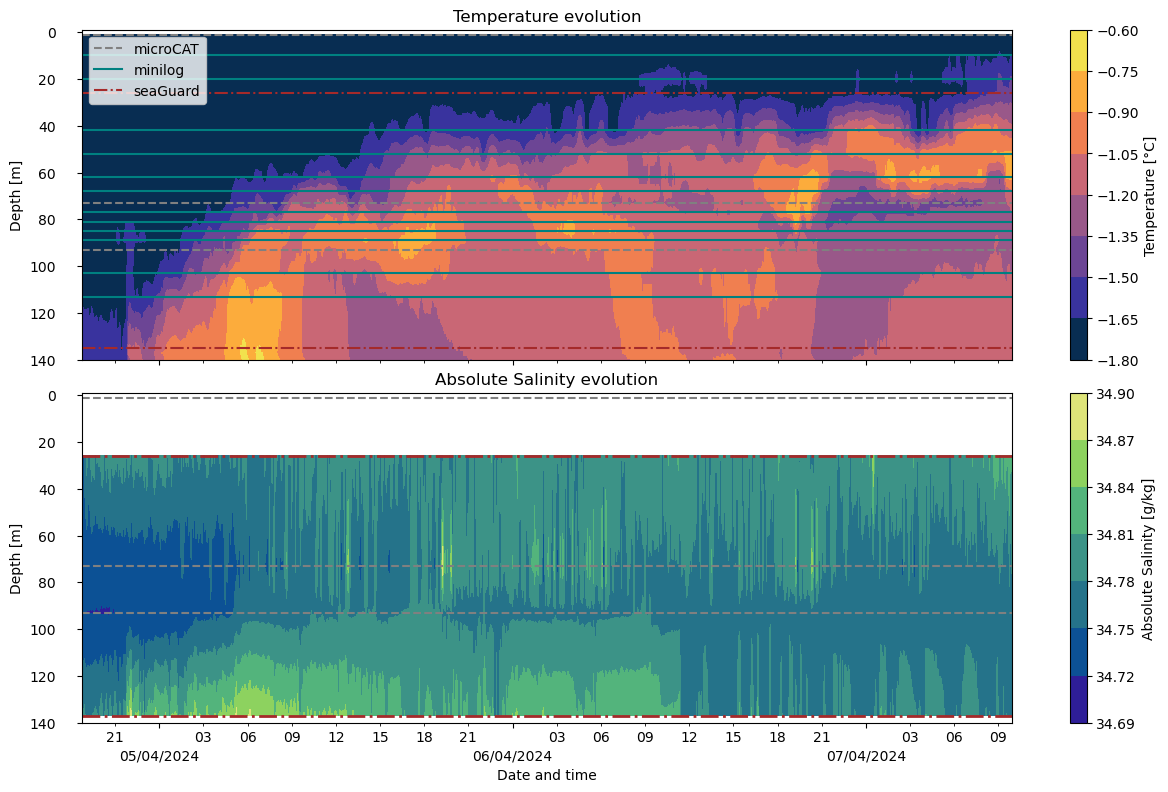

In [9]:
time = xr_mooring_interp['time'].values
depth =  xr_mooring_interp['depth'].values
temp = np.transpose(xr_mooring_interp['T'].values)
p_sal = np.transpose(xr_mooring_interp['Sp'].values)
abs_sal = np.transpose(xr_mooring_interp['Sa'].values)


fig, axs = plt.subplots(2, 1, figsize = (15,9), sharex = True)

contour_T = axs[0].contourf(time, depth, temp, cmap = cmo.thermal)
axs[0].invert_yaxis()
cbarT = fig.colorbar(contour_T, ax=axs[0])
cbarT.set_label('Temperature [°C]')  # Set label for the colorbar


contour_S = axs[1].contourf(time, depth, abs_sal, cmap = cmo.haline)
axs[1].invert_yaxis()
cbarS = fig.colorbar(contour_S, ax=axs[1])
cbarS.set_label('Absolute Salinity [g/kg]')  # Set label for the colorbar

axs[0].set_title('Temperature evolution')
axs[1].set_title('Absolute Salinity evolution')

axs[0].set_ylabel('Depth [m]')
axs[1].set_ylabel('Depth [m]')

axs[1].set_xlabel('Date and time')

axs[0].set_ylim(140, -1)
axs[1].set_ylim(140, -1)


locator_day = mdates.DayLocator()  # Tick on the start day with dd/mm/yyyy
formatter_day = mdates.DateFormatter('%d/%m/%Y')  # Format for displaying date

locator_hr = mdates.HourLocator(byhour = [0, 3, 6, 9, 12, 15, 18, 21])  # Tick every 6 hours
formatter_hr = mdates.DateFormatter('%H')  # Format for displaying hour

axs[1].tick_params(pad=15)
axs[1].xaxis.set_major_locator(locator_day)
axs[1].xaxis.set_major_formatter(formatter_day) 
axs[1].xaxis.set_minor_locator(locator_hr)
axs[1].xaxis.set_minor_formatter(formatter_hr)

axs[0].tick_params(pad=15)
axs[0].xaxis.set_major_locator(locator_day)
axs[0].xaxis.set_major_formatter(formatter_day) 
axs[0].xaxis.set_minor_locator(locator_hr)
axs[0].xaxis.set_minor_formatter(formatter_hr)

plt.subplots_adjust(hspace=0.1)




# PLOTTING INSTRUMENT POSSITIONS IN THE DIAGRAM


color_minilog = 'teal'
color_seabird = 'grey'
color_seaguard = 'brown'

linestyle_minilog = 'solid'
linestyle_seabird = 'dashed'
linestyle_seaguard = 'dashdot'



axs[0].axhline(y=1.2, color =  color_seabird, linestyle= linestyle_seabird, label = 'microCAT')
axs[0].axhline(y=10, color = color_minilog, linestyle= linestyle_minilog, label = 'minilog')
axs[0].axhline(y=20, color = color_minilog, linestyle= linestyle_minilog)
axs[0].axhline(y=26, color = color_seaguard, linestyle= linestyle_seaguard, label = 'seaGuard')
axs[0].axhline(y=42, color = color_minilog, linestyle= linestyle_minilog)
axs[0].axhline(y=52, color = color_minilog, linestyle= linestyle_minilog)
axs[0].axhline(y=62, color = color_minilog, linestyle= linestyle_minilog)
axs[0].axhline(y=68, color = color_minilog, linestyle= linestyle_minilog)
axs[0].axhline(y=73, color = color_seabird, linestyle= linestyle_seabird)
axs[0].axhline(y=77, color = color_minilog, linestyle= linestyle_minilog)
axs[0].axhline(y=81, color = color_minilog, linestyle= linestyle_minilog)
axs[0].axhline(y=85, color = color_minilog, linestyle= linestyle_minilog)
axs[0].axhline(y=89, color = color_minilog, linestyle= linestyle_minilog)
axs[0].axhline(y=93, color = color_seabird, linestyle= linestyle_seabird)
axs[0].axhline(y=103, color = color_minilog, linestyle= linestyle_minilog)
axs[0].axhline(y=113, color = color_minilog, linestyle= linestyle_minilog)
axs[0].axhline(y=135, color = color_seaguard, linestyle= linestyle_seaguard)
axs[0].axhline(y=141, color = color_minilog, linestyle= linestyle_minilog)


axs[1].axhline(y=1.2, color =  color_seabird, linestyle= linestyle_seabird, label = 'microCAT')
axs[1].axhline(y=26, color = color_seaguard, linestyle= linestyle_seaguard, label = 'seaGuard', linewidth = 2)
axs[1].axhline(y=73, color = color_seabird, linestyle= linestyle_seabird)
axs[1].axhline(y=93, color = color_seabird, linestyle= linestyle_seabird)
axs[1].axhline(y=137, color = color_seaguard, linestyle= linestyle_seaguard, linewidth = 2)

axs[0].legend(loc = 'upper left')
#axs[1].legend()

fig.savefig(data_dir + "ContourTempSal.jpg")

# Tidal analysis

# ADCP data 

In [96]:
files = ['a', 'b', 'c']

string = 'lol'

i = 0
for file in files: 
    file = file + string
    files[i] = file
    i += 1

In [97]:
files

['alol', 'blol', 'clol']

In [58]:
ADCP = pd.read_csv(data_dir + "ADCP_TXT.txt",  header = 10, delimiter = "\t")

In [62]:
print(list(ADCP.columns))

['Ens', 'YR', 'MO', 'DA', 'HH', 'MM', 'SS', 'HH.1', 'Unnamed: 8', 'Pit', 'Rol', 'Hea', 'Tem', 'Dep', 'Ori', 'BIT', 'Bat', 'EAA', 'EAA.1', 'EAA.2', 'EAA.3', 'EAA.4', 'EAA.5', 'EAA.6', 'EAA.7', 'EAA.8', 'EAA.9', 'EAA.10', 'EAA.11', 'EAA.12', 'EAA.13', 'EAA.14', 'EAA.15', 'EAA.16', 'EAA.17', 'EAA.18', 'EAA.19', 'EAA.20', 'EAA.21', 'EAA.22', 'EAA.23', 'EAA.24', 'C5', 'C5.1', 'C5.2', 'C5.3', 'C5.4', 'C5.5', 'C5.6', 'C5.7', 'C5.8', 'C5.9', 'C5.10', 'C5.11', 'C5.12', 'C5.13', 'C5.14', 'C5.15', 'C5.16', 'C5.17', 'C5.18', 'C5.19', 'C5.20', 'C5.21', 'C5.22', 'C5.23', 'C5.24', 'Eas', 'Eas.1', 'Eas.2', 'Eas.3', 'Eas.4', 'Eas.5', 'Eas.6', 'Eas.7', 'Eas.8', 'Eas.9', 'Eas.10', 'Eas.11', 'Eas.12', 'Eas.13', 'Eas.14', 'Eas.15', 'Eas.16', 'Eas.17', 'Eas.18', 'Eas.19', 'Eas.20', 'Eas.21', 'Eas.22', 'Eas.23', 'Eas.24', 'Nor', 'Nor.1', 'Nor.2', 'Nor.3', 'Nor.4', 'Nor.5', 'Nor.6', 'Nor.7', 'Nor.8', 'Nor.9', 'Nor.10', 'Nor.11', 'Nor.12', 'Nor.13', 'Nor.14', 'Nor.15', 'Nor.16', 'Nor.17', 'Nor.18', 'Nor.19', '